For a number of galaxies in the GAMA-Legacy catalog, the measured emission line flux from GAMA DR3 is brighter than the measured photometry. Currently `forwardmodel` flags these galaxies since it's difficult to produce a sensible spectra. We examine where these galaxies lie in different parameter spaces.

In [1]:
import h5py
import numpy as np 
# -- feasibgs -- 
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
# read in GAMA-Legacy catalog
cata = Cat.GamaLegacy()
gleg = cata.Read('g15')

In [4]:
# select properties from the GAMA-Legacy catalog
redshift = gleg['gama-spec']['z']
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# apparent magnitude within aperture from Legacy photometry
r_mag_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# r-band magnitude from GAMA (SDSS) photometry
r_mag_gama = gleg['gama-photo']['modelmag_r']
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]
ngal = len(redshift)
print('%i galaxies total' % ngal)

63495 galaxies total


In [5]:
def magnormFLAG(iblock, nblock=13): 
    dir_spec = UT.dat_dir()+'spectra/gamadr3_legacydr7/'
    # read in gleg data
    fblock = h5py.File(dir_spec+'gleg.g15.darksky.seed1.exptime300.'+str(iblock)+'of'+str(nblock)+'blocks.hdf5', 'r')
    block = {}
    for g in fblock.keys():
        block[g] = {} 
        for k in fblock[g].keys(): 
            block[g][k] = fblock[g][k].value
            
    magnorm_flag = ~block['forwardmodel']['magnorm_flag']

    print('magnorm flag raised for %i out of %i targets' % (np.sum(magnorm_flag), len(magnorm_flag)))

    # write out fail galaxies
    flag_block = {} 
    for g in block.keys(): 
        flag_block[g] = {}
        for k in block[g].keys():
            flag_block[g][k] = block[g][k][magnorm_flag]
    return block, flag_block

magnorm flag raised for 28 out of 5000 targets
magnorm flag raised for 22 out of 5000 targets
magnorm flag raised for 29 out of 5000 targets
magnorm flag raised for 23 out of 5000 targets
magnorm flag raised for 4 out of 5000 targets
magnorm flag raised for 11 out of 5000 targets
magnorm flag raised for 4 out of 5000 targets
magnorm flag raised for 8 out of 5000 targets
magnorm flag raised for 6 out of 5000 targets
magnorm flag raised for 18 out of 5000 targets
magnorm flag raised for 31 out of 5000 targets
magnorm flag raised for 18 out of 5000 targets
magnorm flag raised for 15 out of 3495 targets
217


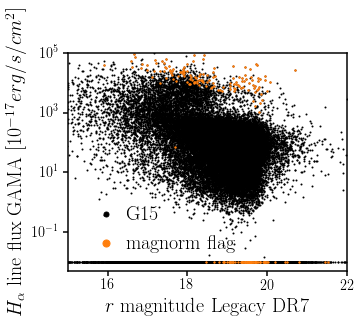

In [6]:
fig = plt.figure(figsize=(5, 4))
sub = fig.add_subplot(111)
# entire G15 field
hasha = (gama_ha > 0)
sub.scatter(r_mag_legacy[hasha], gama_ha[hasha], s=1, c='k', label='G15')
sub.scatter(r_mag_legacy[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=1, c='k')

blocks_ha, blocks_r_mag = [], []  
for i in range(1,14):
    _, flag_block = magnormFLAG(i)
    # redrock fails for each block
    block_ha = flag_block['gama-spec']['ha_flux']
    block_r_mag = UT.flux2mag(flag_block['legacy-photo']['flux_r'])
    
    blocks_ha.append(block_ha)
    blocks_r_mag.append(block_r_mag)

blocks_ha = np.concatenate(blocks_ha)
blocks_r_mag = np.concatenate(blocks_r_mag)
print len(blocks_ha)
hasha = (blocks_ha > 0.)
sub.scatter(blocks_r_mag[hasha], blocks_ha[hasha], s=2, c='C1', label='magnorm flag')
sub.scatter(blocks_r_mag[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=2, c='C1')
sub.legend(loc='lower left', markerscale=5, handletextpad=0., fontsize=20)
sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_ylim([5e-3, 1e5])
sub.set_yscale('log')

(15.0, 22.0)

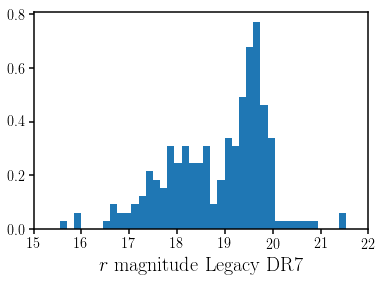

In [7]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.hist(blocks_r_mag, density=True, bins=40)
sub.set_xlabel('$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])

The $r$ magnitude distribution of objects that have GAMA emission line measurements that are brighter than its photometry. Perhaps unsurprisingly, these objects are faint with strong emission lines. It's unclearly how this affects the redshift success rate at the moment. 

(0.0, 6.0)

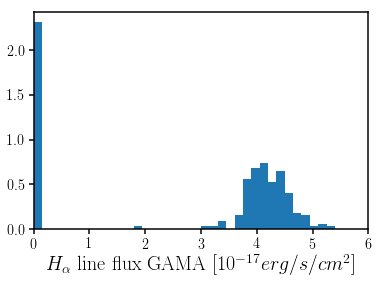

In [8]:
blocks_ha_lowlim = blocks_ha.copy()
blocks_ha_lowlim[np.where(~hasha)] = 10**0.1
fig = plt.figure()
sub = fig.add_subplot(111)
_ = sub.hist(np.log10(blocks_ha_lowlim), range=(0., 6.), bins=40, density=True)
sub.set_xlabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_xlim([0., 6.])

The H$\alpha$ line flux distribution for `magnorm_flag` galaxies. Surprisingly, ~60% of the objects do not have H$\alpha$ line flux... 

Lets check these objects with no H$\alpha$ line flux to see why they have magntiude normalization issues...

In [9]:
_, flag_block1 = magnormFLAG(1)

flag_block1_r_mag_gama = flag_block1['gama-photo']['modelmag_r']
flag_block1_ha = flag_block1['gama-spec']['ha_flux']
flag_block1_z = flag_block1['gama-spec']['z']

s_bgs = FM.BGSsourceSpectra(wavemin=1500.0, wavemax=2e4)
emline_flux = s_bgs.EmissionLineFlux(flag_block1, dr_gama=3, silent=False)

magnorm flag raised for 28 out of 5000 targets
INFO:io.py:1027:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits


In [31]:
emline_keys = ['oiib', 'oiir', 'hb',  'oiiib', 'oiiir', 'oib', 'oir', 'niib', 'ha', 'niir', 'siib', 'siir']
emline_lambda = [3726., 3729., 4861., 4959., 5007., 6300., 6364., 6548., 6563., 6583., 6717., 6731.]

In [37]:
for ii in range(len(emline_flux)): 
    zwave = s_bgs.basewave.astype(float) * (1.0 + flag_block1_z[ii])
    emmaggies = s_bgs.decamwise.get_ab_maggies(emline_flux[ii] * 1e-17, zwave, mask_invalid=True)
    norm_emmaggies = np.array(emmaggies[s_bgs.normfilter])
    
    if flag_block1_ha[ii] < 0.: 
        print '---------------------------------'
        emnames, emfluxes = [], []
        for k, lam in zip(emline_keys, emline_lambda): 
            zlam = lam * (1. + flag_block1_z[ii])
            if (zlam > 5500.) and (zlam < 7100.): 
                emnames.append(k)
                emfluxes.append(flag_block1['gama-spec'][k+'_flux'][ii])
        print emnames
        print emfluxes
        print flag_block1['gama-spec']['z'][ii]
        print 10**(-0.4*flag_block1_r_mag_gama[ii]), norm_emmaggies[0]

---------------------------------
['hb', 'oiiib', 'oiiir']
[-261.21262, 3218.692, -2423.9849]
0.37931
1.0538673498062567e-08 1.266292804577764e-08
---------------------------------
['hb', 'oiiib', 'oiiir']
[6451.23, 3101.6558, 8609.087]
0.35343
1.634216077368255e-08 6.898338467737612e-08
---------------------------------
['hb', 'oiiib', 'oiiir']
[6888.5, 1710.1582, 4822.1377]
0.32272
1.4934494292654094e-08 4.7349411472678886e-08
---------------------------------
['hb', 'oiiib', 'oiiir']
[6998.2485, 813.93164, 4970.8237]
0.28296
2.4591683970560567e-08 4.087960552376385e-08
---------------------------------
['hb', 'oiiib', 'oiiir']
[21431.799, 10752.844, 22958.38]
0.36143
2.9406239067158793e-08 2.1227774304089664e-07
---------------------------------
['hb', 'oiiib', 'oiiir']
[1370.637, 783.46405, 2406.3696]
0.32663
1.0702539686263027e-08 1.636681519067406e-08
---------------------------------
['hb', 'oiiib', 'oiiir']
[10511.036, -1051.3018, 4582.0557]
0.29266
2.2191430713959166e-08 4.820

 These objects generally have H$\beta$ and OIII lines that redshift into the DECAM $r$ band.